In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
from tqdm import tqdm
from sklearn.model_selection import train_test_split


/home/scf73/Insights-Databowl/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/scf73/Insights-Databowl/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/scf73/Insights-Databowl/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/scf73/Insights-Databowl/env/lib/python3.6/s

 # Convolutional Neural Nets

We can pose this problem as a set of interactions between 1 rusher, 11 defenders, and 10 offense players trying to help the rusher. From this angle, we can construct a matrix of 10 defense x 11 offense and perform convolutions to relate their positions and velocities. To do this, we construct a convolutional neural net.

 ## Data Import

 We've already done a lot of feature engineering in a different notebook, so
 this will be brief. We're going to drop a lot of the columns as well, since we
 only use player speeds and positions.

In [2]:
raw_data = pd.read_csv("../data/fe_data.csv", index_col=[1])
raw_data.head()


,GameId,Unnamed: 0,Team,X,Y,S,A,Orientation,Dir,Season,...,Formation_SINGLEBACK,Formation_WILDCAT,PlayerBMI,TimeDelta,PlayerAge,IsRusher,YardsLeft,IsOffense,YardLine_adj,X_adj
PlayId,,,,,,,,,,,,,,,,,,,,,
20170907000118,2017090700,0,False,46.09,34.84,4.0,1.13,278.01,182.82,2017,...,0,0,28.749228,1.0,28.692760,False,35,False,35,1.09
20170907000118,2017090700,1,False,45.33,32.64,0.1,1.35,332.39,161.30,2017,...,0,0,35.993600,1.0,28.457305,False,35,False,35,0.33
20170907000118,2017090700,2,False,46.00,33.20,3.1,0.59,356.99,157.27,2017,...,0,0,33.744000,1.0,28.629790,False,35,False,35,1.00
20170907000118,2017090700,3,False,48.54,27.70,0.2,0.54,0.23,254.36,2017,...,0,0,30.619556,1.0,34.795430,False,35,False,35,3.54
20170907000118,2017090700,4,False,50.68,35.42,1.6,2.43,347.37,195.69,2017,...,0,0,27.935571,1.0,30.061685,False,35,False,35,5.68


In [3]:
keep_columns = ["IsOffense","IsRusher","X","Y","S","A","Dir","Yards"]
data = raw_data[keep_columns]
data.head()


,IsOffense,IsRusher,X,Y,S,A,Dir,Yards
PlayId,,,,,,,,
20170907000118,False,False,46.09,34.84,4.0,1.13,182.82,8
20170907000118,False,False,45.33,32.64,0.1,1.35,161.30,8
20170907000118,False,False,46.00,33.20,3.1,0.59,157.27,8
20170907000118,False,False,48.54,27.70,0.2,0.54,254.36,8
20170907000118,False,False,50.68,35.42,1.6,2.43,195.69,8


 Some of these plays don't have data on all 22 players. We filter these out.
 Fortunately, we only lose about 24 plays.

In [4]:
indices = data.index.unique()

wrong_shape = []
for i in tqdm(indices):
    if data.loc[i].shape != (22,len(keep_columns)):
        wrong_shape.append(i)

data = data.drop(wrong_shape)
data.shape


100%|██████████| 30703/30703 [00:06<00:00, 5008.58it/s]


(674938, 8)

 Let's engineer the components of each player's velocity. First we need to
 understand how to interpret the `Dir` variable.

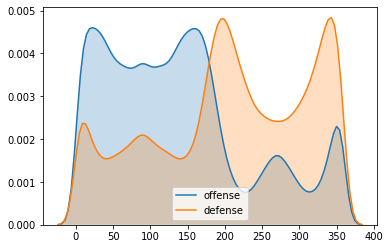

In [5]:
sns.kdeplot(data.loc[data.IsOffense,'Dir'], shade=True, label='offense')
sns.kdeplot(data.loc[~data.IsOffense,'Dir'], shade=True, label='defense')
plt.legend()
plt.show()


 Because the offense is usually pushing toward positive X, we can understand
 that $S_x = S \times sin(Dir)$ and $S_y = S \times -cos(Dir)$.

In [6]:
dir_rad = np.deg2rad(data.Dir)
S_x = data.S * np.sin(dir_rad)
S_y = -data.S * np.cos(dir_rad)

data['S_x'] = S_x
data['S_y'] = S_y


 We can verify that we're correctly assigning the x speed by comparing offense
 and defense. Offense should generally have a positive x speed while defense
 should have a negative one, which we see below.

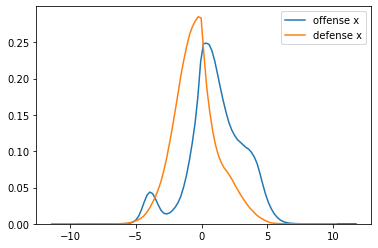

In [7]:
sns.kdeplot(S_x.loc[data.IsOffense], label='offense x')
sns.kdeplot(S_x.loc[~data.IsOffense], label='defense x')
plt.legend()
plt.show()


 ## Data Reformatting
 We break down the dataframe into a list of dataframes, where each entry
 contains a dataframe representing a play. We then convert them to numpy
 matrices, so that the first dimension is the play, second is the player, third
 is the feature.

 We have to `expand_dims` for the rusher because numpy squeezes out the player
 dimension and we want it to have the same dimensionality as the other arrays.

In [8]:
# Split data into play lists
cols = ['X', 'Y', 'S_x', 'S_y']

off_axis = 1 # the axis along which the offensive player changes
def_axis = 2 # the axis along which the defensive player changes

df = data.loc[:,cols]

In [10]:
# Split offense and defense data
off_data = df.loc[data.IsOffense & ~data.IsRusher]
def_data = df.loc[~data.IsOffense]
rus_data = df.loc[data.IsRusher]

split_plays = lambda df: [df.loc[i,:] for i in tqdm(df.index.unique())]

#plays = split_plays(data)
off_plays = split_plays(off_data)
def_plays = split_plays(def_data)
rus_plays = split_plays(rus_data)

off_m = np.array([df.values for df in off_plays])
def_m = np.array([df.values for df in def_plays])
rus_m = np.array([df.values for df in rus_plays])

# Expand and repeat arrays to match shapes
off_m = np.expand_dims(off_m, axis=def_axis).repeat(11, def_axis)
def_m = np.expand_dims(def_m, axis=off_axis).repeat(10, off_axis)

rus_m = np.expand_dims(rus_m, off_axis).repeat(10, off_axis)
rus_m = np.expand_dims(rus_m, def_axis).repeat(11, def_axis)

print("Offense data shape", off_m.shape)
print("Defense data shape", def_m.shape)
print("Rusher data shape", rus_m.shape)


100%|██████████| 30679/30679 [00:03<00:00, 8444.19it/s]


Offense data shape (30679, 10, 11, 4)
Defense data shape (30679, 10, 11, 4)
Rusher data shape (30679, 10, 11, 4)


 ## Feature Engineering

 Now we engineer specific features from the columns we collected. The shape of
 our "image" is 10 offensive players x 11 defensive players. We will represent
 scalar features, such as those for the rusher, as a constant values across the
 matrix and 1-D features as repeating across the appropriate axis.

 ### Defender

 This layer consists of two features:

 - defender $S_x$
 - defender $S_y$


 It does not include any information about the offense or the rusher

In [11]:
# Defender velocity feature
def_vel = def_m[:,:,:,2:]
def_vel.shape


(30679, 10, 11, 2)

 ### Offense-Defense layer

 These features compare the (x,y) positions of the offensive and defensive
 players. This builds five features:

 - x distance
 - y distance
 - x relative speed
 - y relative speed
 - euclidean distance


 This way the model is trained on both the absolute euclidean distance (so it
 doesn'have to calculate that) as well as each of its components, which
 preserve directionality as well.

In [12]:
# X and Y components of relative position and velocity
off_def_rel_comp = off_m - def_m

# Euclidean distance
off_def_ed = np.sqrt(np.square(off_def_rel_comp[:,:,:,:2]).sum(axis=3))
off_def_ed = np.expand_dims(off_def_ed, 3)

off_def = np.concatenate([off_def_rel_comp, off_def_ed], axis=3)
off_def.shape


(30679, 10, 11, 5)

 ### Defender vs. Rusher

 The distances from the defenders to the rusher. Five features:

 - x distance
 - y distance
 - x relative speed
 - y relative speed
 - euclidean distance


 The procedure is similar to the offensive vs. defensive positions

In [13]:
# Components speed & velocity
def_rus_rel_comp = def_m - rus_m

# Euclidean distance
def_rus_ed = np.sqrt(np.square(def_rus_rel_comp[:,:,:,:2]).sum(axis=3))
def_rus_ed = np.expand_dims(def_rus_ed, 3)

def_rus = np.concatenate([def_rus_rel_comp, def_rus_ed], axis=3)
def_rus.shape


(30679, 10, 11, 5)

In [14]:
target = data.loc[data.IsRusher, "Yards"]

def pdf(n):
    arr = [0] * 199
    arr[n+99] = 1
    return arr

features = [
    def_vel,
    off_def,
    def_rus
]

x = np.concatenate(features, axis=3)
y = target.values.astype(np.int)

x_train, x_test, y_train, y_test = train_test_split(x,y)

y_min, y_max = -25, 50

y_train = np.array( list(map(pdf, y_train.clip(y_min, y_max))) )
y_test = np.array( list(map(pdf,y_test)) )

print("X shape:", x.shape)
print("Y shape:", y_train.shape)


X shape: (30679, 10, 11, 12)
Y shape: (23009, 199)


 ## Build model
 We use three layers of 2D convolution over both offense and defense, then two layers of 1D convolution over the offense axis. Finally, we have one hidden dense layer connected to our output.

In [15]:
def compile_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(x.shape[1:], name='input'),
        
        tf.keras.layers.Conv2D(128, kernel_size=(1,1), strides=(1,1), activation='relu'),
        tf.keras.layers.Conv2D(160, kernel_size=(1,1), strides=(1,1), activation='relu'),
        tf.keras.layers.Conv2D(128, kernel_size=(1,1), strides=(1,1), activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(10,1)),
        
        tf.keras.layers.Lambda(lambda y: K.squeeze(y,1)),

        tf.keras.layers.Conv1D(96, kernel_size=1, strides=1, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(96, kernel_size=1, strides=1, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool1D(pool_size=11),
        
        tf.keras.layers.Lambda(lambda y: K.squeeze(y,1)),
        
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(199, activation='softmax', name='output')
    ])

    mse = tf.keras.losses.MeanSquaredError()
    def pdf_CRPS(y_true_pdf, y_pred_pdf):
        y_true_cdf = tf.math.cumsum(y_true_pdf, axis=1)
        y_pred_cdf = tf.math.cumsum(y_pred_pdf, axis=1)

        return mse(y_true_cdf, y_pred_cdf)

    model.compile(optimizer='adam', loss=pdf_CRPS)
    return model

stop = tf.keras.callbacks.EarlyStopping()
model = compile_model()
model.summary()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 11, 128)       1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 11, 160)       20640     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 11, 128)       20608     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 11, 128)        0         
_________________________________________________________________
lambda (Lambda)              (None, 11, 128)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 11, 96)            12384     
____

In [16]:
history = model.fit(x_train, y_train, 
    epochs=20,
    validation_split=0.2,
    shuffle=False,
    callbacks=[]
)


Train on 18407 samples, validate on 4602 samples
Epoch 1/20
18407/18407 [==============================] - 7s 366us/sample - loss: 0.0176 - val_loss: 0.0139
Epoch 2/20
18407/18407 [==============================] - 4s 237us/sample - loss: 0.0137 - val_loss: 0.0246
Epoch 3/20
18407/18407 [==============================] - 4s 230us/sample - loss: 0.0133 - val_loss: 0.0131
Epoch 4/20
18407/18407 [==============================] - 4s 230us/sample - loss: 0.0128 - val_loss: 0.0127
Epoch 5/20
18407/18407 [==============================] - 4s 230us/sample - loss: 0.0125 - val_loss: 0.0125
Epoch 6/20
18407/18407 [==============================] - 4s 234us/sample - loss: 0.0124 - val_loss: 0.0125
Epoch 7/20
18407/18407 [==============================] - 4s 236us/sample - loss: 0.0123 - val_loss: 0.0123
Epoch 8/20
18407/18407 [==============================] - 4s 237us/sample - loss: 0.0122 - val_loss: 0.0123
Epoch 9/20
18407/18407 [==============================] - 4s 234us/sample - loss: 0.012

 ## Training Report

        loss  val_loss
15  0.011652  0.011858
16  0.011587  0.012413
17  0.011549  0.012014
18  0.011464  0.011957
19  0.011440  0.012228


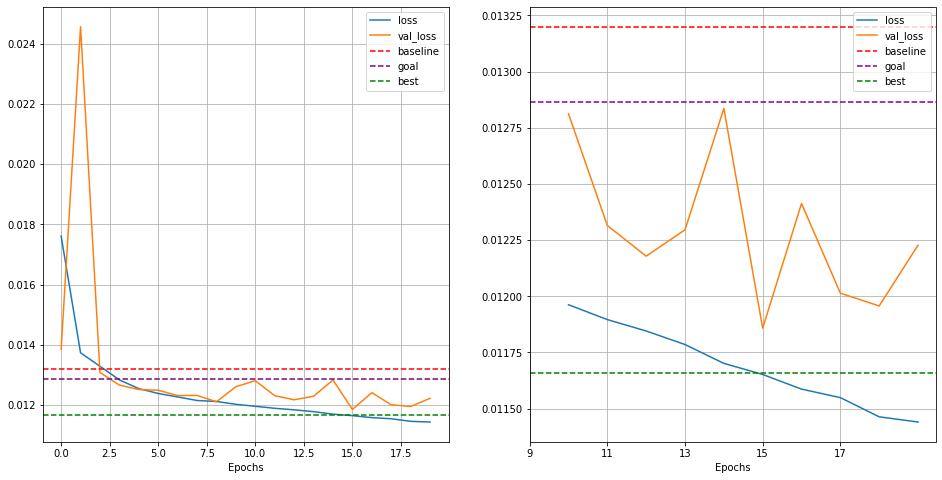

In [17]:
hist = pd.DataFrame(history.history)
fig, axes = plt.subplots(1,2, figsize=(16,8))
baseline_mse = 0.013200
goal_mse = 0.012864
best_mse = 0.011658

for start,ax in zip([0,-10], axes):
    ax.plot(hist.loss[start:], label='loss')
    ax.plot(hist.val_loss[start:], label='val_loss')

    ax.axhline(baseline_mse, label='baseline', c='red', ls='--')
    ax.axhline(goal_mse, label='goal', c='purple', ls='--')
    ax.axhline(best_mse, label='best', c='green', ls='--')
    
    ax.legend()
    ax.grid()

    ax.set_xlabel("Epochs")

axes[1].set_xticks(np.arange(start % hist.index.max(), hist.index.max(), 2))

print(hist.tail(5))
fig.show()


 ## Model Scoring

In [18]:
model.evaluate(x_test, y_test)


7670/7670 [==============================] - 0s 59us/sample - loss: 0.0121


0.012131341638570504